### Datasetsof Friends of Friends

一般情况下，使用二度好友（好友的好友）作为推荐的候选集。假设平均每人有150个好友，差不多有22500个二度好友，数据量基本满足推荐候选集的需求，并且数据表明，绝大部分（92%左右）的好友关系都建立在二度空间。基于三元闭包理论进行好友推荐，推荐的用户至少有一个共同好友，也变相的确定使用二度好友进行推荐，使用如下公式计算：

<div align="center">
<img src="resources/fof_graph.png" width="600"/>
</div>

<div align="center">
<img src="resources/fof_equation.png" width="300"/>
</div>

#### 参考资料
1. Facebook好友推荐算法: https://zhuanlan.zhihu.com/p/20533434
2. Serving a Billion Personalized News Feeds: https://www.youtube.com/watch?v=Xpx5RYNTQvg
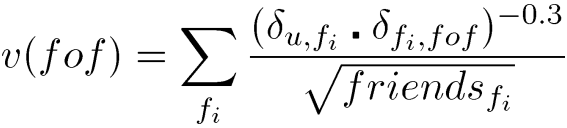
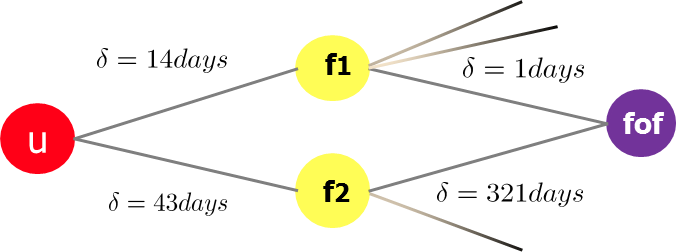

In [1]:
import sys
import pandas as pd

from pyspark.sql import Window, functions as F
from pyspark.ml.feature import QuantileDiscretizer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [30]:
import metaspore as ms

spark_confs={
        "spark.network.timeout":"500",
        "spark.sql.codegen.wholeStage": "false"
}

spark = ms.spark.get_session(local=True,
                             app_name='soc-pokec Demo',
                             batch_size=256,
                             worker_count=2,
                             server_count=2,
                             worker_memory='10G',
                             server_memory='10G',
                             coordinator_memory='10G',
                             spark_confs=spark_confs)

22/07/15 02:33:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, LongType, StringType
import pyspark.sql.functions as F

profile_colunm_names = ['user_id', 'public', 'completion_percentage', 'gender', 'region', 'last_login', 'registration',
                        'AGE', 'body', 'I_am_working_in_field', 'spoken_languages', 'hobbies', 'I_most_enjoy_good_food',
                        'pets', 'body_type', 'my_eyesight', 'eye_color', 'hair_color', 'hair_type', 'completed_level_of_education',
                        'favourite_color', 'relation_to_smoking', 'relation_to_alcohol', 'sign_in_zodiac',
                        'on_pokec_i_am_looking_for', 'love_is_for_me', 'relation_to_casual_sex', 'my_partner_should_be',
                        'marital_status', 'children', 'relation_to_children', 'I_like_movies', 'I_like_watching_movie',
                        'I_like_music', 'I_mostly_like_listening_to_music', 'the_idea_of_good_evening', 'I_like_specialties_from_kitchen',
                        'fun', 'I_am_going_to_concerts', 'my_active_sports', 'my_passive_sports', 'profession', 'I_like_books',
                        'life_style', 'music', 'cars', 'politics', 'relationships', 'art_culture', 'hobbies_interests',
                        'science_technologies', 'computers_internet', 'education', 'sport', 'movies', 'travelling', 'health',
                        'companies_brands', 'more']
relationship_colunm_names = ['user_id', 'friend_id']

profile_schema = StructType([StructField(cn, StringType(), True) for cn in profile_colunm_names])
relationship_schema = StructType([StructField(cn, LongType(), True) for cn in relationship_colunm_names])

profile_dataset = spark.read.csv('s3://dmetasoul-bucket/demo/datasets/soc-pokec/soc-pokec-profiles.txt', sep='\t', schema=profile_schema, header=False, inferSchema=False)
relationship_dataset = spark.read.csv('s3://dmetasoul-bucket/demo/datasets/soc-pokec/soc-pokec-relationships.txt', sep='\t', schema=relationship_schema, header=False, inferSchema=False)

profile_dataset = profile_dataset.withColumn('user_id', F.col('user_id').cast(LongType()))
profile_dataset = profile_dataset.orderBy(F.col('user_id')).limit(16000)
max_user_id = profile_dataset.agg({"user_id": "max"}).collect()[0]['max(user_id)']
relationship_dataset = relationship_dataset.filter((F.col('user_id') <= max_user_id) & (F.col('friend_id') <= max_user_id))

profile_dataset = profile_dataset.withColumn('user_id', F.col('user_id').cast(StringType()))
relationship_dataset = relationship_dataset.withColumn('user_id', F.col('user_id').cast(StringType()))
relationship_dataset = relationship_dataset.withColumn('friend_id', F.col('friend_id').cast(StringType()))

In [4]:
profile_dataset.limit(10).toPandas()

22/07/15 02:24:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,user_id,public,completion_percentage,gender,region,last_login,registration,AGE,body,I_am_working_in_field,spoken_languages,hobbies,I_most_enjoy_good_food,pets,body_type,my_eyesight,eye_color,hair_color,hair_type,completed_level_of_education,favourite_color,relation_to_smoking,relation_to_alcohol,sign_in_zodiac,on_pokec_i_am_looking_for,love_is_for_me,relation_to_casual_sex,my_partner_should_be,marital_status,children,relation_to_children,I_like_movies,I_like_watching_movie,I_like_music,I_mostly_like_listening_to_music,the_idea_of_good_evening,I_like_specialties_from_kitchen,fun,I_am_going_to_concerts,my_active_sports,my_passive_sports,profession,I_like_books,life_style,music,cars,politics,relationships,art_culture,hobbies_interests,science_technologies,computers_internet,education,sport,movies,travelling,health,companies_brands,more
0,1,1,14,1,"zilinsky kraj, zilina",2012-05-25 11:20:00.0,2005-04-03 00:00:00.0,26,"185 cm, 90 kg",it,anglicky,"sportovanie, spanie, kino, jedlo, pocuvanie hu...",v dobrej restauracii,mam psa,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,2,1,62,0,"zilinsky kraj, kysucke nove mesto",2012-05-25 23:08:00.0,2007-11-30 00:00:00.0,0,"166 cm, 58 kg",null,nemecky,"turistika, prace okolo domu, praca s pc, pocuv...",pri svieckach s partnerom,macka,priemerna,vyborny,zelene,cierne,dlhe,"zakladne, ale som uz na strednej skole dufam z...","cierna, modra, ruzova",nefajcim,"pijem prilezitostne, iba ked sa nieco kona a t...",byk,"dobreho priatela, priatelku, mozno aj viac","nie je nic lepsie, ako byt zamilovany(a)",iba s mojou laskou,laskou mojho zivota,slobodny(a),no budu a tak chcem 2 deti staci a tak ked bud...,v buducnosti chcem mat deti,"komedie, romanticke",doma z gauca,"disko, pop, rap a jasn eto co teraz leti najvi...","na diskoteke, pri chodzi",pri svieckach s partnerom,slovenskej,"<div> <a title=""vstup do klubu"" href=""/klub/pr...",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,3,0,38,1,"bratislavsky kraj, bratislava - karlova ves",2012-05-10 18:05:00.0,2010-05-23 00:00:00.0,29,null,"reklamy a medii, sluzieb a obchodu","anglicky, nemecky","sportovanie, cestovanie",null,null,null,null,zelene,hnede,null,null,"cierna, modra",null,null,null,"dobreho priatela, priatelku, niekoho na chatov...",null,null,null,slobodny(a),null,null,"akcne, horory, komedie, sci-fi, dokumentarne, ...",null,"rock, metal, house, techno, pop, oldies, jazz","v aute, v praci, na koncerte, s partnerom",null,"slovenskej, talianskej, japonskej",null,pravidelne,"hokej, futbal, auto-moto sporty, squash","auto-moto sporty, futbal, hokej",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,4,1,12,0,"banskobystricky kraj, brezno",2011-12-29 12:25:00.0,2011-12-29 00:00:00.0,26,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,5,1,66,1,"zilinsky kraj, zilina",2012-05-25 01:10:00.0,2006-05-29 00:00:00.0,26,null,som nezamestnany,"anglicky, nemecky, pascal","sportovanie, prace v zahrade, pc hry, pocuvani...",v dobrej restauracii,"nemam ziadne, nemam rad zvierata zo vseobecnos...",vysportovana,ze vraj pridavaju na inteligencii...no neviem:),"zelene, a trocha hnedej k tomu","hnede, kedysi som ol blondak ale uz sa za to n...",kratke,"bakalarske, ale este ne som nadumany:)","hneda, modra, zelena",nefajcim,pozitivny,"byk, ale byk na mna nejako nesedi tak neviem k...","dobreho priatela, priatelku, niekoho na chatov...","v laske som sa sklamal(a), preto som velmi opa...",null,"mojou chybajucou polovickou, vydrzat moj spev",slobodny(a),null,null,"horory, komedie, romanticke, s

In [5]:
relationship_dataset.limit(10).toPandas()

,user_id,friend_id
0,1,13
1,1,11
2,1,6
3,1,3
4,1,4
5,1,5
6,1,15
7,1,14
8,1,7
9,1,8


In [ ]:
relationship_df = relationship_dataset.alias('t1').join(profile_dataset.alias('t2'), on=F.col('t1.user_id')==F.col('t2.user_id'), how='leftouter') \
                .select(F.col('t1.*'),
                        F.col('t2.gender').alias('user_gender'),
                        F.col('t2.AGE').alias('user_age'),
                        F.col('t2.completion_percentage').alias('user_completion_percentage'))

relationship_df = relationship_df.alias('t1').join(profile_dataset.alias('t2'), on=F.col('t1.friend_id')==F.col('t2.user_id'), how='leftouter') \
                .select(F.col('t1.*'),
                        F.col('t2.gender').alias('friend_gender'),
                        F.col('t2.AGE').alias('friend_age'),
                        F.col('t2.completion_percentage').alias('friend_completion_percentage'),
                        F.col('t2.last_login').alias('friend_last_act_time'))

relationship_df = relationship_df.select(F.lit('1').alias('label'), '*')

splits = relationship_df.randomSplit([0.9, 0.1], 24)
train_dataset, test_dataset = splits[0], splits[1]
item_dataset = (
    relationship_df
    .withColumn('rn', F.row_number().over(
        Window.partitionBy('friend_id').orderBy(F.col('user_id'))
    ))
    .filter('rn == 1')
    .drop(F.col('rn'))
)

print('train dataset count: ', train_dataset.count())
print('test dataset count: ', test_dataset.count())
print('item dataset count: ', item_dataset.count())

train dataset count:  197518


test dataset count:  21940


In [7]:
train_dataset.limit(5).toPandas()

,label,user_id,friend_id,user_gender,user_age,user_completion_percentage,friend_gender,friend_age,friend_completion_percentage,friend_last_act_time
0,1,1,10,1,26,14,0,22,64,2012-05-14 21:54:00.0
1,1,1,11,1,26,14,0,22,45,2012-05-21 16:31:00.0
2,1,1,12,1,26,14,1,26,67,2012-04-30 16:24:00.0
3,1,1,13,1,26,14,0,0,28,2012-03-26 16:40:00.0
4,1,1,14,1,26,14,0,0,41,2012-05-25 23:19:41.0


In [8]:
train_dataset.write.parquet('s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/fof_train_dataset.parquet', mode="overwrite")
test_dataset.write.parquet('s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/fof_test_dataset.parquet', mode="overwrite")
item_dataset.write.parquet('s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/fof_item_dataset.parquet', mode="overwrite")

22/07/15 02:31:08 WARN S3AInstrumentation: Closing output stream statistics while data is still marked as pending upload in OutputStreamStatistics{blocksSubmitted=1, blocksInQueue=1, blocksActive=0, blockUploadsCompleted=0, blockUploadsFailed=0, bytesPendingUpload=0, bytesUploaded=5599, blocksAllocated=1, blocksReleased=1, blocksActivelyAllocated=0, exceptionsInMultipartFinalize=0, transferDuration=0 ms, queueDuration=0 ms, averageQueueTime=0 ms, totalUploadDuration=0 ms, effectiveBandwidth=0.0 bytes/s}
22/07/15 02:31:10 WARN S3AInstrumentation: Closing output stream statistics while data is still marked as pending upload in OutputStreamStatistics{blocksSubmitted=1, blocksInQueue=1, blocksActive=0, blockUploadsCompleted=0, blockUploadsFailed=0, bytesPendingUpload=0, bytesUploaded=4756, blocksAllocated=1, blocksReleased=1, blocksActivelyAllocated=0, exceptionsInMultipartFinalize=0, transferDuration=0 ms, queueDuration=0 ms, averageQueueTime=0 ms, totalUploadDuration=0 ms, effectiveBandw

In [9]:
!aws s3 ls s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/

                           PRE fof_item_dataset.parquet/
                           PRE fof_test_dataset.parquet/
                           PRE fof_train_dataset.parquet/
                           PRE item_dataset.parquet/
                           PRE profile_dataset.parquet/
                           PRE relationship_dataset.parquet/
                           PRE test_dataset.parquet/
                           PRE test_dataset_rank.parquet/
                           PRE train_dataset.parquet/
                           PRE train_dataset_rank.parquet/


### Implementation of SQL version 

In [10]:
train_dataset = spark.read.parquet('s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/fof_train_dataset.parquet')
test_dataset = spark.read.parquet('s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/fof_test_dataset.parquet')

In [11]:
train_dataset.limit(5).toPandas()

,label,user_id,friend_id,user_gender,user_age,user_completion_percentage,friend_gender,friend_age,friend_completion_percentage,friend_last_act_time
0,1,1,10,1,26,14,0,22,64,2012-05-14 21:54:00.0
1,1,1,11,1,26,14,0,22,45,2012-05-21 16:31:00.0
2,1,1,12,1,26,14,1,26,67,2012-04-30 16:24:00.0
3,1,1,13,1,26,14,0,0,28,2012-03-26 16:40:00.0
4,1,1,14,1,26,14,0,0,41,2012-05-25 23:19:41.0


In [12]:
test_dataset.limit(5).toPandas()

,label,user_id,friend_id,user_gender,user_age,user_completion_percentage,friend_gender,friend_age,friend_completion_percentage,friend_last_act_time
0,1,1,3,1,26,14,1,29,38,2012-05-10 18:05:00.0
1,1,1,9,1,26,14,0,0,12,2012-03-03 16:57:00.0
2,1,10,264,0,22,64,0,22,67,2012-04-11 11:42:00.0
3,1,10,301,0,22,64,1,0,43,2012-05-21 21:53:00.0
4,1,10,303,0,22,64,1,0,12,2012-05-24 12:19:00.0


In [13]:
max_recommendation_count=100
key_column_name='key'
value_column_name = 'value'

In [14]:
### u2i
train_dataset.registerTempTable('train_dataset')  
query="""
select 
    ta.user_id,
    ta.friend_id,
    1/sqrt(tb.friend_count) as rel_score
from
    train_dataset ta
join
(
    select 
        user_id, 
        count(distinct friend_id) as friend_count
    from 
        train_dataset
    group by
        user_id
) tb
on ta.user_id=tb.user_id
"""
u2i_table = spark.sql(query)

In [15]:
### u2u2i
u2i_table.registerTempTable('u2i_table')  
query ="""
select 
    ta.user_id, 
    tb.friend_id as friend_id,
    sum(ta.rel_score * tb.rel_score) as rel_score
from
    u2i_table ta
join
    u2i_table tb
on 
    ta.friend_id=tb.user_id
where 
    ta.user_id<>tb.friend_id
group by 
    ta.user_id,
    tb.friend_id
"""
u2u2i_table = spark.sql(query)

In [16]:
u2u2i_table.registerTempTable('u2u2i_table')
query ="""
select
    ta.*
from
    u2u2i_table as ta
left outer join
    u2i_table as tb
on 
    ta.user_id=tb.user_id and ta.friend_id=tb.friend_id
where 
    tb.friend_id is null
"""
u2u2i_table_filter = spark.sql(query)

In [17]:
### u2u2i limit
u2u2i_table = u2u2i_table_filter
from pyspark.sql import Window
result = u2u2i_table.withColumn("rn", F.row_number().over(Window.partitionBy('user_id').orderBy(F.desc('rel_score')))) \
                    .filter(f"rn <= %d"%max_recommendation_count)  \
                    .groupBy('user_id') \
                    .agg(F.collect_list(F.struct(F.col('friend_id').alias('_1'), F.col('rel_score').alias('_2'))).alias(value_column_name)) \
                    .withColumnRenamed('user_id', key_column_name)

In [18]:
result.limit(20).toPandas()

/opt/spark/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: ArrayType(StructType(List(StructField(_1,StringType,true),StructField(_2,DoubleType,true))),false)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,key,value
0,10096,"[(9855, 0.5461221656607032), (9234, 0.28616281..."
1,10351,"[(13589, 0.19889203985640455), (8246, 0.190870..."
2,10436,"[(1852, 0.24120226591665972), (10574, 0.239990..."
3,1090,"[(9402, 0.2583257787638619), (1027, 0.23847141..."
4,11078,"[(11154, 0.4443228517153313), (13343, 0.401798..."
5,11332,"[(11269, 0.18087530099319418), (11270, 0.18087..."
6,11563,"[(424, 0.3779644730092272), (11335, 0.37796447..."
7,1159,"[(73, 0.17284022790078232), (832, 0.1551567577..."
8,11722,"[(11461, 0.033767600672658715), (12953, 0.0337..."
9,11888,"[(343, 0.2357022603955159), (11046, 0.20412414..."


In [19]:
str_schema = 'array<struct<name:string,_2:double>>'
on = test_dataset['user_id']==result['key']
test_result = test_dataset.alias('t1').join(result.alias('t2'), on=on, how='left_outer')\
                          .select('t1.*', 't2.value')\
                          .withColumn('rec_info', F.col('value').cast(str_schema))
test_result

DataFrame[label: string, user_id: string, friend_id: string, user_gender: string, user_age: string, user_completion_percentage: string, friend_gender: string, friend_age: string, friend_completion_percentage: string, friend_last_act_time: string, value: array<struct<_1:string,_2:double>>, rec_info: array<struct<name:string,_2:double>>]

In [20]:
from pyspark.mllib.evaluation import RankingMetrics
prediction_label_rdd = test_result.rdd.map(lambda x:(\
                                        [xx.name for xx in x.rec_info] if x.rec_info is not None else [], \
                                        [getattr(x, 'friend_id')]))

recall_metrics = RankingMetrics(prediction_label_rdd)
print("Debug -- Precision@20: ", recall_metrics.precisionAt(20))
print("Debug -- Recall@20: ", recall_metrics.recallAt(20))
print("Debug -- MAP@20: ", recall_metrics.meanAveragePrecisionAt(20))

Debug -- Precision@20:  0.01498632634457611


Debug -- Recall@20:  0.29972652689152235


Debug -- MAP@20:  0.11960744734746306


### Implementation of Spark Functions

In [21]:
train_dataset = spark.read.parquet('s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/fof_train_dataset.parquet')
test_dataset = spark.read.parquet('s3://dmetasoul-bucket/demo/datasets/soc-pokec/demo_fg/fof_test_dataset.parquet')

In [22]:
train_dataset.limit(5).toPandas()

,label,user_id,friend_id,user_gender,user_age,user_completion_percentage,friend_gender,friend_age,friend_completion_percentage,friend_last_act_time
0,1,1,10,1,26,14,0,22,64,2012-05-14 21:54:00.0
1,1,1,11,1,26,14,0,22,45,2012-05-21 16:31:00.0
2,1,1,12,1,26,14,1,26,67,2012-04-30 16:24:00.0
3,1,1,13,1,26,14,0,0,28,2012-03-26 16:40:00.0
4,1,1,14,1,26,14,0,0,41,2012-05-25 23:19:41.0


In [23]:
test_dataset.limit(5).toPandas()

,label,user_id,friend_id,user_gender,user_age,user_completion_percentage,friend_gender,friend_age,friend_completion_percentage,friend_last_act_time
0,1,1,3,1,26,14,1,29,38,2012-05-10 18:05:00.0
1,1,1,9,1,26,14,0,0,12,2012-03-03 16:57:00.0
2,1,10,264,0,22,64,0,22,67,2012-04-11 11:42:00.0
3,1,10,301,0,22,64,1,0,43,2012-05-21 21:53:00.0
4,1,10,303,0,22,64,1,0,12,2012-05-24 12:19:00.0


In [24]:
def u2f_table(dataset, 
              last_act_time, 
              time_format='yyyy-MM-dd HH:mm:ss', 
              decay_max=10000,
              decay_factor=-0.3):
    item_count = dataset.groupBy(F.col('user_id'))\
                        .agg(F.countDistinct('friend_id').alias('friend_count'))
    rel_score = dataset.alias('ta').join(item_count.alias('tb'), F.col('ta.user_id')==F.col('tb.user_id'), how='inner')\
                       .select('ta.*', 'tb.friend_count')\
                       .withColumn('rel_score', F.lit(1)/F.sqrt(F.col('tb.friend_count')))
    if last_act_time:
        rel_score = rel_score.withColumn('day_diff', F.datediff(F.to_date(F.current_timestamp()),
                                                                F.to_date(last_act_time, time_format)))
        rel_score = rel_score.withColumn('day_diff',  F.when(F.col('day_diff')>F.lit(decay_max), F.lit(decay_max)).otherwise(F.col('day_diff')))
        rel_score = rel_score.withColumn('rel_score', F.col('rel_score') * F.pow(F.col('day_diff'), decay_factor))
    return rel_score


def u2fof_table(u2f_table, walk_length=1, filter_u2f=True, max_recommendation_count=100):
    u2fof_table = u2f_table
    for i in range(0, walk_length):
        on_cond = F.col('ta.friend_id')==F.col('tb.user_id')
        u2fof_table = u2fof_table.alias('ta').join(u2f_table.alias('tb'), on=on_cond, how='inner') \
                                 .filter(F.col('ta.user_id')!=F.col('tb.friend_id')) \
                                 .groupBy(F.col('ta.user_id'), F.col('tb.friend_id')) \
                                 .agg(F.sum(F.col('ta.rel_score') * F.col('tb.rel_score')).alias('rel_score'))
    
    if filter_u2f:
        on_cond = (F.col('ta.user_id')==F.col('tb.user_id'))&(F.col('ta.friend_id')==F.col('tb.friend_id'))
        u2fof_table = u2fof_table.alias('ta').join(u2f_table.alias('tb'), on=on_cond, how='left_outer') \
                                 .select(F.col('ta.*'))\
                                 .filter(F.col('tb.friend_id').isNull())
    
    u2fof_table = u2fof_table.withColumn("rn", F.row_number().over(Window.partitionBy('user_id').orderBy(F.desc('rel_score')))) \
                             .filter(f"rn <= %d"%max_recommendation_count)  \
                             .groupBy('user_id') \
                             .agg(F.collect_list(F.struct(F.col('friend_id').alias('_1'), F.col('rel_score').alias('_2'))).alias(value_column_name)) \
                             .withColumnRenamed('user_id', key_column_name)
    return u2fof_table


def transform_test(test_dataset, u2fof_table):
    str_schema = 'array<struct<name:string,_2:double>>'
    on = test_dataset['user_id']==u2fof_table['key']
    test_result = test_dataset.alias('t1').join(u2fof_table.alias('t2'), on=on, how='left_outer')\
                              .select('t1.*', 't2.value')\
                              .withColumn('rec_info', F.col('value').cast(str_schema))
    return test_result


def evaluate(test_result):
    from pyspark.mllib.evaluation import RankingMetrics
    prediction_label_rdd = test_result.rdd.map(lambda x:(\
                                            [xx.name for xx in x.rec_info] if x.rec_info is not None else [], \
                                            [getattr(x, 'friend_id')]))

    recall_metrics = RankingMetrics(prediction_label_rdd)
    return recall_metrics

In [25]:
max_recommendation_count=100
key_column_name='key'
value_column_name = 'value'

In [26]:
u2f_table = u2f_table(train_dataset, 'friend_last_act_time', time_format='yyyy-MM-dd HH:mm:ss.S')
u2f_table.limit(3).toPandas()

,label,user_id,friend_id,user_gender,user_age,user_completion_percentage,friend_gender,friend_age,friend_completion_percentage,friend_last_act_time,friend_count,rel_score,day_diff
0,1,1,10,1,26,14,0,22,64,2012-05-14 21:54:00.0,12,0.024516,3714
1,1,1,11,1,26,14,0,22,45,2012-05-21 16:31:00.0,12,0.024530,3707
2,1,1,12,1,26,14,1,26,67,2012-04-30 16:24:00.0,12,0.024489,3728


In [27]:
u2fof_table = u2fof_table(u2f_table)
u2fof_table.limit(10).toPandas()

/opt/spark/python/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: ArrayType(StructType(List(StructField(_1,StringType,true),StructField(_2,DoubleType,true))),false)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,key,value
0,10096,"[(9855, 0.0038469873252428947), (9234, 0.00205..."
1,10351,"[(13589, 0.0014348043492401889), (8246, 0.0013..."
2,10436,"[(1852, 0.0017402368068584872), (13813, 0.0017..."
3,1090,"[(9402, 0.0018577673082271614), (1027, 0.00171..."
4,11078,"[(11154, 0.0032048990098004107), (13343, 0.002..."
5,11332,"[(11269, 0.0013018160325917435), (11270, 0.001..."
6,11563,"[(424, 0.00273098146589856), (11335, 0.0027254..."
7,1159,"[(73, 0.001239669583035508), (832, 0.001120557..."
8,11722,"[(12953, 0.00024310518128794226), (8524, 0.000..."
9,11888,"[(343, 0.0017030661625036798), (5935, 0.001474..."


In [28]:
test_result = transform_test(test_dataset, u2fof_table)
recall_metrics = evaluate(test_result)
print("Debug -- Precision@20: ", recall_metrics.precisionAt(20))
print("Debug -- Recall@20: ", recall_metrics.recallAt(20))
print("Debug -- MAP@20: ", recall_metrics.meanAveragePrecisionAt(20))

Debug -- Precision@20:  0.014972652689152226


Debug -- Recall@20:  0.29945305378304465


Debug -- MAP@20:  0.11941158407433236


In [29]:
spark.stop()